<a href="https://colab.research.google.com/github/Abhinav-Marlingaplar/AI-Project/blob/main/AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **CREDIT CARD FRAUD DETECTION USING ARTIFICIAL NEURAL NETWORK**
#### **Name - Abhinav Marlingaplar**
#### **Roll no - 2023BCD0013**

#### **STEP 1: Identify the Problem**

*   Problem Definition:
Credit card fraud detection is a binary classification problem where the goal is to identify fraudulent transactions from legitimate ones based on transaction data.

*   Objective:
Build an Artificial Neural Network (ANN) that predicts whether a transaction
is fraudulent (1) or legitimate (0).

*   Expected Output:
A model capable of identifying frauds with high recall (catching as many frauds as possible)
while maintaining good precision.

#### **STEP 2: Import Libraries**

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

import keras_tuner as kt
import shap
import warnings
warnings.filterwarnings('ignore')

#### **STEP 3: Load and explore the dataset**

Here, the dataset is loaded from my Google Drive.

Dataset Link - https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

Dataset Details:
*   Source: European cardholders, September 2013 transactions
*   Rows: 284,807
*   Frauds: 492 (≈0.172%) → highly imbalanced dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Colab Datasets/creditcard.csv'
df = pd.read_csv(file_path)
print(df.shape)
df.head()


Mounted at /content/drive
(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
print(df.info())
print(df.describe())
print(df['Class'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

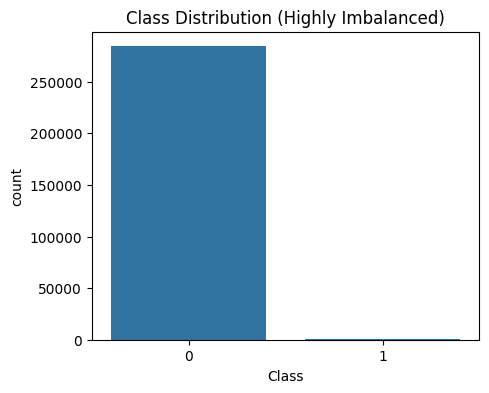

In [ ]:
plt.figure(figsize=(5,4))
sns.countplot(x='Class', data=df)
plt.title("Class Distribution (Highly Imbalanced)")
plt.show()

#### **STEP 4: Preparation of Data (Preprocessing)**

Structured Data:
All 30 features are numerical; most have been PCA-transformed except 'Time' and 'Amount'.

Tasks:

1.   Normalize numerical columns
2.   Handle data imbalance using SMOTE
3.   Split into training and testing sets


In [ ]:
# Split features and labels
X = df.drop('Class', axis=1)
y = df['Class']

In [ ]:
# Split BEFORE scaling or SMOTE to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Standardize 'Time' and 'Amount' based on training data
scaler = StandardScaler()
X_train[['Time', 'Amount']] = scaler.fit_transform(X_train[['Time', 'Amount']])
X_test[['Time', 'Amount']] = scaler.transform(X_test[['Time', 'Amount']])

In [ ]:
# Apply SMOTE ONLY on training data to handle imbalance
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("After SMOTE (Train only):", X_train_res.shape)
print("Resampled class distribution:\n", y_train_res.value_counts())

After SMOTE (Train only): (454902, 30)
Resampled class distribution:
 Class
0    227451
1    227451
Name: count, dtype: int64


#### **STEP 5: Define a Stable Model Builder for Tuning**

We choose an Artificial Neural Network (ANN) since:

*   It can learn nonlinear relationships between input features and output.
*   Performs well on structured tabular data when tuned properly.



#### **Architecture Design**

<table style="width:100%; border-collapse: collapse; border: 2px solid black;">
  <tr style="background-color:#f2f2f2;">
    <th style="padding:10px; border:1px solid black;">Layer Type</th>
    <th style="padding:10px; border:1px solid black;">Description</th>
    <th style="padding:10px; border:1px solid black;">Activation Function</th>
    <th style="padding:10px; border:1px solid black;">Purpose / Notes</th>
  </tr>

  <tr>
    <td style="padding:10px; border:1px solid black;">Input Layer</td>
    <td style="padding:10px; border:1px solid black;">
      Accepts standardized numerical features from the dataset (input_dim = number of features).
    </td>
    <td style="padding:10px; border:1px solid black;">—</td>
    <td style="padding:10px; border:1px solid black;">
      Feeds normalized inputs to the first hidden layer.
    </td>
  </tr>

  <tr>
    <td style="padding:10px; border:1px solid black;">Hidden Layer 1</td>
    <td style="padding:10px; border:1px solid black;">
      Dense layer with 64 neurons followed by Batch Normalization.
    </td>
    <td style="padding:10px; border:1px solid black;">ReLU</td>
    <td style="padding:10px; border:1px solid black;">
      Learns initial complex feature representations; BN stabilizes and accelerates training.
    </td>
  </tr>

  <tr>
    <td style="padding:10px; border:1px solid black;">Dropout Layer 1</td>
    <td style="padding:10px; border:1px solid black;">
      Randomly drops 40% of neurons.
    </td>
    <td style="padding:10px; border:1px solid black;">—</td>
    <td style="padding:10px; border:1px solid black;">
      Provides strong regularization to reduce overfitting in early layers.
    </td>
  </tr>

  <tr>
    <td style="padding:10px; border:1px solid black;">Hidden Layer 2</td>
    <td style="padding:10px; border:1px solid black;">
      Dense layer with 32 neurons followed by Batch Normalization.
    </td>
    <td style="padding:10px; border:1px solid black;">ReLU</td>
    <td style="padding:10px; border:1px solid black;">
      Captures deeper non-linear relationships in the data.
    </td>
  </tr>

  <tr>
    <td style="padding:10px; border:1px solid black;">Dropout Layer 2</td>
    <td style="padding:10px; border:1px solid black;">
      Drops 30% of neurons during training.
    </td>
    <td style="padding:10px; border:1px solid black;">—</td>
    <td style="padding:10px; border:1px solid black;">
      Prevents overfitting in deeper layers and improves generalization.
    </td>
  </tr>

  <tr>
    <td style="padding:10px; border:1px solid black;">Hidden Layer 3</td>
    <td style="padding:10px; border:1px solid black;">
      Dense layer with 16 neurons followed by Batch Normalization.
    </td>
    <td style="padding:10px; border:1px solid black;">ReLU</td>
    <td style="padding:10px; border:1px solid black;">
      Refines learned representations and consolidates high-level patterns.
    </td>
  </tr>

  <tr>
    <td style="padding:10px; border:1px solid black;">Dropout Layer 3</td>
    <td style="padding:10px; border:1px solid black;">
      Drops 20% of neurons.
    </td>
    <td style="padding:10px; border:1px solid black;">—</td>
    <td style="padding:10px; border:1px solid black;">
      Adds an additional layer of regularization before final prediction.
    </td>
  </tr>

  <tr>
    <td style="padding:10px; border:1px solid black;">Output Layer</td>
    <td style="padding:10px; border:1px solid black;">
      Dense layer with 1 neuron for binary classification.
    </td>
    <td style="padding:10px; border:1px solid black;">Sigmoid</td>
    <td style="padding:10px; border:1px solid black;">
      Outputs probability of a transaction being fraudulent (1) or legitimate (0).
    </td>
  </tr>
</table>


In [ ]:
# This function builds the ANN model dynamically so that
# keras-tuner can adjust layer sizes, learning rates, etc.

def build_stable_model(hp):
    model = Sequential()

    # First hidden layer
    model.add(Dense(
        units=hp.Int('units_1', min_value=16, max_value=64, step=16),
        input_dim=X_train_res.shape[1],
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Choice('l2_1', [0.0005, 0.001, 0.005]))
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Choice('dropout_1', [0.2, 0.3, 0.4])))

    # Second hidden layer
    model.add(Dense(
        units=hp.Int('units_2', min_value=8, max_value=32, step=8),
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Choice('l2_2', [0.0005, 0.001, 0.005]))
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Choice('dropout_2', [0.2, 0.3, 0.4])))

    # Third hidden layer
    model.add(Dense(
        units=hp.Int('units_3', min_value=4, max_value=16, step=4),
        activation='relu'
    ))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

#### **STEP 6: Hyperparameter Tuning with Keras Tuner**

In [ ]:
tuner = kt.RandomSearch(
    build_stable_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='credit_fraud_ann_tuning'
)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

tuner.search(X_train_res, y_train_res,
             epochs=10,
             validation_split=0.2,
             callbacks=[early_stop],
             batch_size=64,
             verbose=1)

Trial 3 Complete [00h 03m 31s]
val_accuracy: 0.9999890327453613

Best val_accuracy So Far: 0.9999890327453613
Total elapsed time: 00h 10m 35s


In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest hyperparameters:")
for param, val in best_hp.values.items():
    print(f"{param}: {val}")


Best hyperparameters:
units_1: 64
l2_1: 0.005
dropout_1: 0.3
units_2: 16
l2_2: 0.0005
dropout_2: 0.4
units_3: 12
learning_rate: 0.0005


#### **STEP 7: Train Final Tuned Model**

In [ ]:
final_model = tuner.hypermodel.build(best_hp)
print("\nFinal Tuned Model Architecture:\n")
final_model.summary()


Final Tuned Model Architecture:



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 12)             │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,609 (14.10 KB)

 Trainable params: 3,425 (13.38 KB)

 Non-trainable params: 184 (736.00 B)

In [ ]:
history = final_model.fit(
    X_train_res, y_train_res,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/15
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9259 - loss: 0.2829 - val_accuracy: 0.9913 - val_loss: 0.0516
Epoch 2/15
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9859 - loss: 0.0607 - val_accuracy: 0.9991 - val_loss: 0.0239
Epoch 3/15
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9897 - loss: 0.0471 - val_accuracy: 0.9994 - val_loss: 0.0219
Epoch 4/15
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9911 - loss: 0.0417 - val_accuracy: 1.0000 - val_loss: 0.0194
Epoch 5/15
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9925 - loss: 0.0382 - val_accuracy: 0.9983 - val_loss: 0.0254
Epoch 6/15
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9925 - loss: 0.0378 - val_accuracy: 0.9992 - val_loss: 0.0196
Epoch 7/15
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9930 - loss: 0.0364 - val_accuracy: 0.9997 - val_loss: 0.0187
Epoch 8/15
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9935 - loss: 0

#### **STEP 8: Evaluate the Tuned Model**

In [ ]:
# Evaluate on both training and test sets
train_loss, train_acc = final_model.evaluate(X_train_res, y_train_res, verbose=0)
test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)

In [ ]:
# Predictions
y_pred = (final_model.predict(X_test) > 0.5).astype(int)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.40      0.90      0.55        98

    accuracy                           1.00     56962
   macro avg       0.70      0.95      0.78     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.947818927796217
Training Accuracy: 0.9988
Testing Accuracy: 0.9975


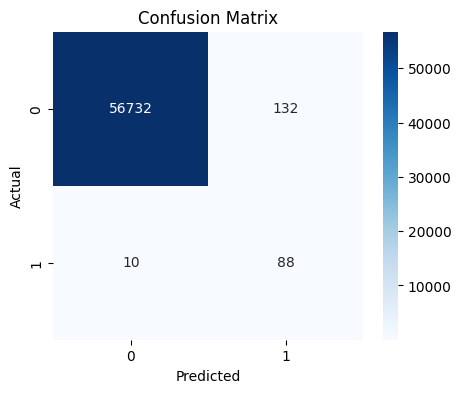

In [ ]:
# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


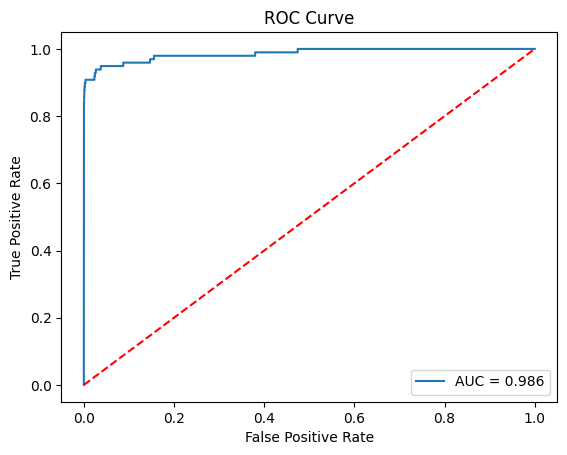

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, final_model.predict(X_test))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, final_model.predict(X_test)):.3f}")
plt.plot([0,1],[0,1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


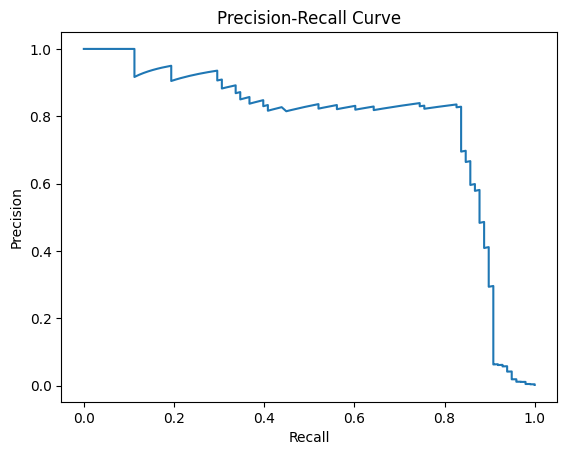

In [ ]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, final_model.predict(X_test))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

### **STEP 9: Visualize Training History**

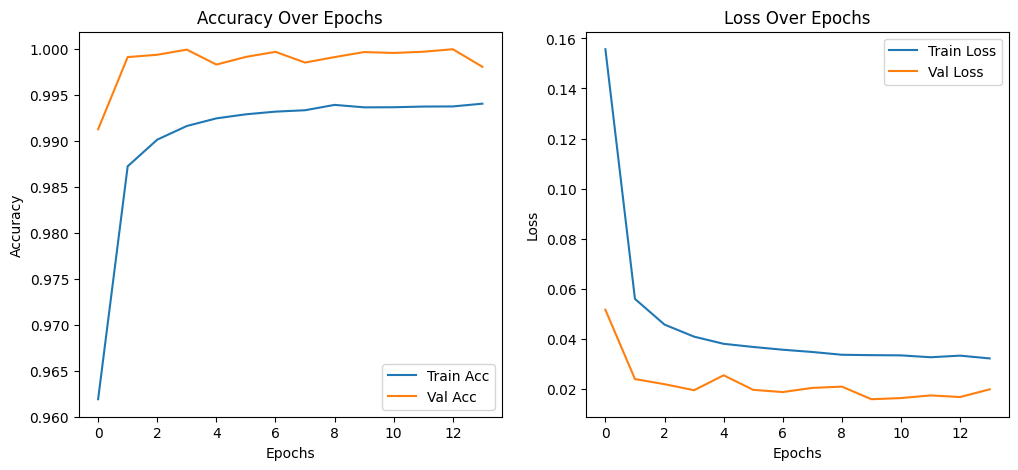

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### **STEP 10: Explainability with SHAP**

PermutationExplainer explainer: 101it [00:22,  3.01it/s]


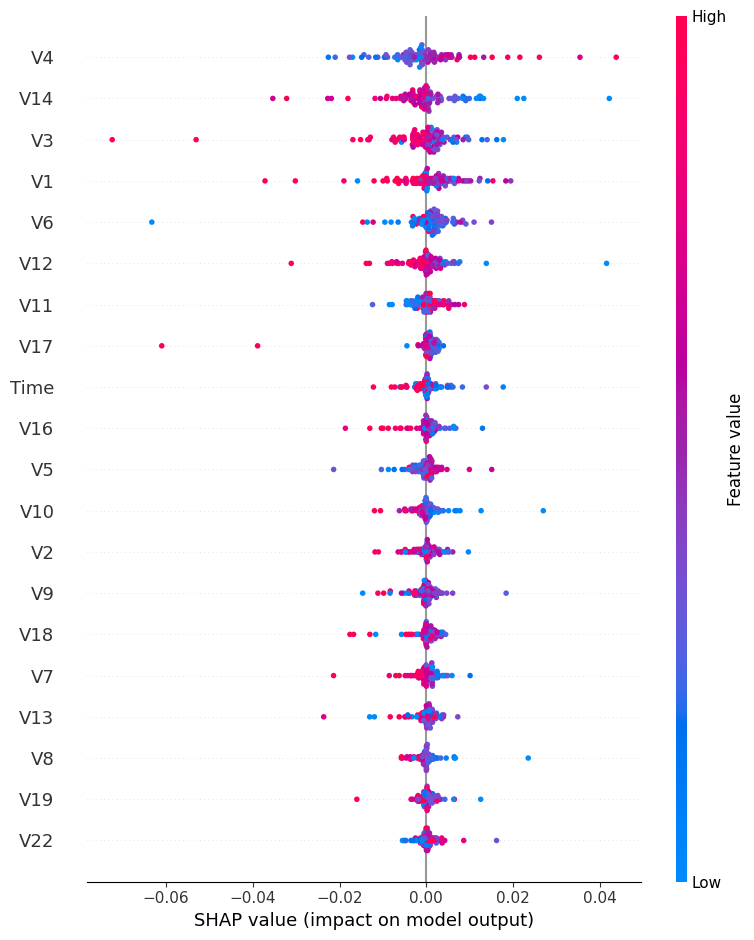

In [ ]:
explainer = shap.Explainer(final_model, X_test[:100])
shap_values = explainer(X_test[:100])
shap.summary_plot(shap_values, X_test[:100])

#### **STEP 11: Save Final Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

final_model.save("/content/drive/MyDrive/credit_card_fraud_ann_model.keras")
print("Model saved permanently to Google Drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved permanently to Google Drive


### **Conclusion**

The final ANN model demonstrates excellent overall performance with a testing accuracy of 99.75% and a ROC-AUC score of 0.9478, indicating strong discriminatory power between fraudulent and legitimate transactions. While the model maintains perfect precision and recall for legitimate transactions, it achieves a recall of 0.90 for fraud detection — effectively capturing most fraudulent cases. The results show that the model is well-generalized, with minimal overfitting and reliable detection capability for rare fraud instances.